# Data Programming - Assignment 3
## Combining geographical numerical and textual data

In this assignment you will combine weather and geonames data to find Europe's windiest cities.

Open a terminal and issue the following commands:

`$ conda install basemap
$ pip install wget
`

Accept all to install the extra packages required.

In [2]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import wget
import csv

For this assignment you will need to download the following 3 files. The first one is ~343MB.

`http://iit.demokritos.gr/~iaklampanos/assign3_data.npz
http://iit.demokritos.gr/~iaklampanos/lat.npy
http://iit.demokritos.gr/~iaklampanos/lon.npy
http://download.geonames.org/export/dump/cities5000.zip`


**(1) Write a generic function to download a file from the Web (given a URL), if it is not already present locally. The function should be parameterisable w.r.t. the local directory to be used, the default being the current working directory (`./`). Use this function to assign values to variables `data_filename`, `lat_filename` and `lon_filename`. [2 marks]**

*Hint: Use the wget package.*

*Hint: When developing use the smaller `lat.npy` or `lon.npy`.*

*Optional: Implement a function to allow wget to display the download progress in %. Try to find your way using `help(wget)` and by looking up the source code of wget online.*

In [15]:
import os.path

def get_file_name(web_file):

    if not web_file:
        sys.exit('Please give a valid URL')

    URL=web_file.split("/")
    return URL[-1]


def file_exists(file_name,local_dir):
    if not file_name:
        sys.exit("Please give a valid file name")

    #Appending slash--Creating valid path    
    if local_dir[-1]!="/":
        local_dir+="/"
    path=local_dir+file_name

    if os.path.exists(path):
        return 1
    return 0
        
        
def fetch_data(web_file, local_dir='.'):
    """Download the `web_file`, assuming it is a web resource into the local_dir. 
    If a file with the same filename already exists in the local directory, do not 
    download it but return its path instead.
    Arguments:
        web_file: a web resource identifiable by a url (str)
        local_dir: a local directory to download the web_file into (str)
    Return: The local path to the file (str)
    """
    #extracting file name
    file_name=get_file_name(web_file)
    
    if not file_exists(file_name,local_dir):
        return wget.download(web_file, out=local_dir)
    
    return file_name

dest_dir="/home/gelou/Desktop/"
#data_filename = fetch_data('http://iit.demokritos.gr/~iaklampanos/assign3_data.npz',dest_dir) 
lat_filename = fetch_data('http://iit.demokritos.gr/~iaklampanos/lat.npy', dest_dir)
lon_filename = fetch_data('http://iit.demokritos.gr/~iaklampanos/lon.npy',dest_dir)
#cities_filename = fetch_data('http://download.geonames.org/export/dump/cities5000.zip',dest_dir)

The first three pieces of data you have downloaded are all numpy arrays which you can deserialise using `np.load`, as shown below.

In [10]:
#data = np.load(data_filename)['c137']
lat = np.load(lat_filename)
lon = np.load(lon_filename)

The geonames data (`cities5000.zip`) contains a text file (`cities5000.txt`) of tab-separated values. The description of this data is at http://download.geonames.org/export/dump/readme.txt. It lists the geographical locations and names of the cities with a population > 5000. 

**Unzip `cities5000.zip` to obtain `cities5000.txt`.**

In [25]:
#Unziping cities5000.zip
def extract_file(filename,local_dir):
    """If cities5000.txt does not exits, unzip cities5000.zip and remove it
        *Note, assuming that the file name is the same in both compressed and uncompressed format.
        Only file extention (zip/txt) differ.
    """
    if not file_exists(filename+".txt",local_dir):

        import zipfile
        zip_ref = zipfile.ZipFile(local_dir + filename+".zip", 'r')
        zip_ref.extractall(dest_dir)
        zip_ref.close()

        #removing zip file
        os.remove(local_dir+filename+".zip")

extract_file("cities5000",dest_dir)

/home/gelou/Desktop/cities5000.zip


** (2) In this exercise we will need to extract the fields geonamesid, name, asciiname, 
latitude, longitude, contry code, population, elevation, dem and time zone (10 in total). Write a (*very* basic) class providing a human-readable enumeration to the fields above, corresponding to the format of the `cities5000.txt` file. [2 marks] **

*Hint: e.g. for the field time zone, which is the 17th field in the file, we want to write F.TZ instead of 17. This will make our code more readable and more maintainable (e.g. in case the format changes in the future).*

In [148]:
class F(object):
    geonamesid=0
    name=0
    asciiname=0
    latityde=0
    longtitude=0
    country_code=0
    population=0
    elevation=0
    dem=0
    time_zone=0
    
    def __init__(self,elements):
        self.geonamesid=elements[0]
        self.name=elements[1]
        self.asciiname=elements[2]
        self.latitude=elements[3]
        self.longtitude=elements[4]
        self.country_code=elements[5]
        self.population=elements[6]
        self.elevation=elements[7]
        self.dem=elements[8]
        self.time_zone=elements[9]
       
        
    def get_lat(self):
        return self.latitude
    def get_long(self):
        return self.longtitude
    def get_population(self):
        return self.population

** (3) Write a function to read cities5000.txt into a Python list, retaining the fields geonamesid, name, asciiname, latitude, longitude, contry code, population, elevation, dem and time zone. Use the class you defined above. [2 marks] **

In [149]:
import pandas

def load_cities(filename='cities5000.txt'):
    """Parse cities5000.txt and return a list containing a subset of its fields."""
    
    #Selecting the columns
    coln_index=[0,1,2,4,5,8,14,15,16,17] 
    obj_list=[]
    #Reading csv into np array
    table = pandas.read_csv(dest_dir+"cities5000.txt", usecols=coln_index, delimiter="\t",header=0).as_matrix()

    #Calling User Defined Constructor
    obj_list=[F(i) for i in table]
    return obj_list
    
cities = load_cities()

**(4) Write a function that given a list of cities in the format above it selects cities based on their latitude and longitude, and minimum population. We want all cities within two pairs of (lat,long), with a population >= `population`. Use your function to get all european cities (coordinates provided below) with a population >= 100000 [2 marks] **

In [174]:
def latlong_filter(lat1, lon1, lat2, lon2, population=5000, cities=cities):
    """Return a sublist of the geonames cities from a northwestern point (`lat1`, `lon1`) 
       to a southeastern point (`lat2`, `lon2`) and with a minimum population of `population`
    """
    eur_cities=[i for i in cities if  i.get_population() >= population \
                and i.get_lat()>=lat2 and  i.get_lat()<=lat1\
                and i.get_long()>=lon1 and  i.get_long()<=lon2]
            
    return eur_cities

LAT1 = 58.070942
LON1 = -9.493621
LAT2 = 34.103214
LON2 = 29.686365
european_cities = latlong_filter(LAT1, LON1, LAT2, LON2, 100000)

Back to the `data` variable... `data` has been previously used in a classification experiment and has a complicated structure. We will use only part of it. Each row has 5 data fields: 
* [0] a human-readable name
* [1] an id
* [2] a date & time
* [3] a 501x501 shape
* [4] a 3x3x64x64 shape

For our exercise we will use fields 2, the datetime, and 4. 4 corresponds to weather snapshots averaged over 78hr periods (3 days and 6hrs). Datetimes and weathers repeat over 2-year periods. We need to extract the datetimes and their corresponding weathers over a 2-year period, ignoring the rest. This corresponds to 224 records (rows).

**(5) Complete the function below, which should return a *copy* of the first 224 rows of `data` retaining only datetimes and weather. [2 marks]**

In [13]:
def extract_time_weather(data=data, rows=224):
    pass
times_weathers = extract_time_weather()
# assert(times_weathers[0,1][0,0].shape == (64, 64))

The weather component of our data has a shape 3, 3, 64, 64. This corresponds to 3 variables (west-east wind component, south-north wind component, geopotential height), estimated at 3 pressure levels (500, 700, 900 hPa) respectively. The values are provided on a coarse 64x64 grid covering Europe.

We will use wind information and our cities to find the windiest European cities per year season. But first we need to be able to find the cell, in the 64x64 image, which contains a location given a latitude, longitude.

**(6) Complete the function below to convert a latitude, longitude pair into a pair of integers corresponding to the geographical point's coordinates in the 64x64 space. [2 marks]**

*Hint: `convert_to_xy(latitude, longitude) -> x(0-63), y(0, 63)`*

*Hint: use the `lon` and `lat` arrays defined above. Find the indexes of the input cell that is the closest to the arguments. Use the **`haversine()`** distance function provided below.*

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    (https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def convert_to_xy(latitude, longitude):
    """Map the coordinate provided (`latitude`, `longitude`) onto the weather 64x64 grid."""
    pass

**(7) Calculate the wind magnitude and append it into our wind data array. This array must have the same shape as the u- and v-wind component arrays [2] **

*Hint: The magnitudes should have a shape of 3x64x64, i.e. each wind magnitude array (64x64) should correspond to a different pressure level (3 levels in total).*

In [15]:
all_weathers_mags = None

**(8) Calculate the average wind magnitude per season - quarters. Remember that our overall data cover 2 years [2 marks]**

In [ ]:
magnitude_averages = None  

**(9) Using the list of `european_cities` you calculated above, find the 10 windiest cities - i.e. the cities which are located in the cell with the highest magnitude - per season. Make sure you retain their indexes in `european_citites`, or that you also store their geolocation. Take into account only the 900hPa pressure level. [2 marks]**

*Hint: You may want to create a function to avoid repeating code. You will also need to use the function `convert_to_xy` you created above*

In [ ]:
q1_cities = None
q2_cities = None
q3_cities = None
q4_cities = None

**(10) The function below displays a 64x64 data array onto a map. Change it so that it also displays a list of points - you will use this functionality to display city locations. Use your new function to display wind magnitude average and the 10 windiest cities per season. [2 marks]**

*Hint: You will need to create 4 maps, one per season.*

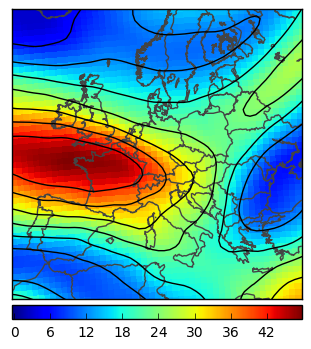

In [17]:
#plt.figure(figsize=(8, 8), dpi= 80)
def display_on_map(data, title=None, lat=lat, lon=lon):
    im = plt.imread('map-pin.png')

    m = Basemap(width=3800E3, height=3800E3,
                resolution='l', projection='lcc', lat_0 = 50, 
                lon_0 = 10, lat_ts = 40, k_0=1.0)
    m.drawcoastlines(linewidth=1.0, color='#444444')
    m.drawcountries(linewidth=1.0, color='#444444')
    m.drawmapboundary(linewidth=1.0, color='#000000')
    x, y = m(lon, lat)
    try:
        pass
        cs = m.contour(x, y, data, linewidths=1.0, colors='k')
    except:
        pass
    pcl = m.pcolor(x, y, np.squeeze(data))
    cbar = m.colorbar(pcl, location='bottom', pad='2%')
    if title:
        plt.title(title)
    plt.show()    
display_on_map(data[0,4][0,0])